<a href="https://colab.research.google.com/github/ArcturusMajere/finalgeog/blob/main/usajoibs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import time, requests

class USAJobsClient:
    def __init__(self, user_email="johnnystuto@live.com", auth_key="O1r4r5dR9OuFg8dyHJD8QBpcEVYOrugWVeiBS6AslRY=",
                 base_url="https://data.usajobs.gov/api/search", rate_delay=0.25, timeout=30):
        self.user_email = user_email
        self.auth_key = auth_key
        self.base_url = base_url
        self.rate_delay = rate_delay
        self.timeout = timeout
        self.headers = {
            "Host": "data.usajobs.gov",
            "User-Agent": self.user_email,
            "Authorization-Key": self.auth_key
        }

    def _request(self, params):
        r = requests.get(self.base_url, headers=self.headers, params=params, timeout=self.timeout)
        r.raise_for_status()
        return r.json()

    def search(self, results_per_page=500, max_pages=None, **query):
        page = 1
        results_per_page = max(1, min(int(results_per_page), 500))
        while True:
            payload = {"ResultsPerPage": results_per_page, "Page": page}
            payload.update({k: v for k, v in query.items() if v is not None})
            data = self._request(payload)
            items = data.get("SearchResult", {}).get("SearchResultItems", []) or []
            for item in items:
                d = item.get("MatchedObjectDescriptor", {}) or {}
                yield {
                    "job_id": d.get("PositionID"),
                    "title": d.get("PositionTitle"),
                    "organization": d.get("OrganizationName"),
                    "department": d.get("DepartmentName"),
                    "locations": [loc.get("LocationName") for loc in d.get("PositionLocation", [])] if d.get("PositionLocation") else [],
                    "salary_min": (d.get("PositionRemuneration", [{}])[0].get("MinimumRange") if d.get("PositionRemuneration") else None),
                    "salary_max": (d.get("PositionRemuneration", [{}])[0].get("MaximumRange") if d.get("PositionRemuneration") else None),
                    "salary_interval": (d.get("PositionRemuneration", [{}])[0].get("RateIntervalCode") if d.get("PositionRemuneration") else None),
                    "open_date": d.get("PublicationStartDate"),
                    "close_date": d.get("ApplicationCloseDate"),
                    "apply_uri": (d.get("ApplyURI", []) or [None])[0]
                }
            count_all = data.get("SearchResult", {}).get("SearchResultCountAll", 0)
            number_pages = int(data.get("SearchResult", {}).get("UserArea", {}).get("NumberOfPages", 0))
            page += 1
            if (max_pages and page > max_pages) or page > max(1, number_pages) or (page - 1) * results_per_page >= count_all:
                break
            time.sleep(self.rate_delay)

def collect_jobs(query_kwargs, results_per_page=100, max_pages=1):
    client = USAJobsClient()
    return list(client.search(results_per_page=results_per_page, max_pages=max_pages, **query_kwargs))

if __name__ == "__main__":
    jobs = collect_jobs({"Keyword": "Data Scientist", "LocationName": "Washington, DC"}, results_per_page=50, max_pages=1)
    print(len(jobs))
    print(jobs[0] if jobs else {})


12
{'job_id': 'DAKB255260801894D', 'title': 'DATA SCIENTIST', 'organization': 'Joint Activities', 'department': 'Department of the Army', 'locations': ['Fort Meade, Maryland'], 'salary_min': '120579', 'salary_max': '164794', 'salary_interval': 'PA', 'open_date': '2025-09-10T06:10:49.1970', 'close_date': '2025-09-19T23:59:59.9970', 'apply_uri': 'https://www.usajobs.gov:443/job/845478100'}


In [3]:
!pip install requests

In [4]:
jobs = collect_jobs(
    {"Keyword": "Data Scientist", "LocationName": "Washington, DC"},
    results_per_page=20,
    max_pages=1
)

print(len(jobs))
print(jobs[0])


12
{'job_id': 'DAKB255260801894D', 'title': 'DATA SCIENTIST', 'organization': 'Joint Activities', 'department': 'Department of the Army', 'locations': ['Fort Meade, Maryland'], 'salary_min': '120579', 'salary_max': '164794', 'salary_interval': 'PA', 'open_date': '2025-09-10T06:10:49.1970', 'close_date': '2025-09-19T23:59:59.9970', 'apply_uri': 'https://www.usajobs.gov:443/job/845478100'}


In [5]:
import pandas as pd

df = pd.DataFrame(jobs)
df.head()


,job_id,title,organization,department,locations,salary_min,salary_max,salary_interval,open_date,close_date,apply_uri
0,DAKB255260801894D,DATA SCIENTIST,Joint Activities,Department of the Army,"[Fort Meade, Maryland]",120579,164794,PA,2025-09-10T06:10:49.1970,2025-09-19T23:59:59.9970,https://www.usajobs.gov:443/job/845478100
1,K-26-DHA-12796011-AKK,DATA SCIENTIST,Air Force Materiel Command,Department of the Air Force,"[Gunter AFB, Alabama, Maxwell AFB, Alabama, Da...",49960,99314,PA,2025-09-09T00:00:00.0000,2025-09-26T23:59:59.9970,https://www.usajobs.gov:443/job/845331500
2,HRM-DE(DHA)-12798802-MEB,Supervisory Data Scientist,Customs and Border Protection,Department of Homeland Security,"[Washington, District of Columbia]",167603,195200,PA,2025-09-15T00:00:00.0000,2025-09-19T23:59:59.9970,https://www.usajobs.gov:443/job/845792200
3,DE-12781554-25-TR,OPERATIONS RESEARCH ANALYST (SENIOR DATA SCIEN...,Surface Transportation Board,Other Agencies and Independent Organizations,"[Washington, District of Columbia]",167603,195200,PA,2025-09-08T14:20:33.3430,2025-09-25T23:59:59.9970,https://www.usajobs.gov:443/job/845291800
4,DE-12792028-25-SS,INTERDISCIPLINARY ENGINEER/SCIENTIST,Naval Air Systems Command,Department of the Navy,"[Patuxent River, Maryland]",142488,195200,PA,2025-09-08T00:00:00.0000,2025-09-26T23:59:59.9970,https://www.usajobs.gov:443/job/845100500


Total last 24h: 1421
Posted today (2025-09-18 PT): 439


,job_id,title,department,organization,open_date,apply_uri
0,25217-13,Recreation Assistant (Beach Adventure Lifeguar...,Department of the Navy,"Commander, Navy Installations",2025-09-18T19:28:14.6570,https://www.usajobs.gov:443/job/846420300
1,25-12804624,MWR Operations Assistant (Marketing),Department of the Navy,"Commander, Navy Installations",2025-09-18T19:17:57.3870,https://www.usajobs.gov:443/job/846420200
2,74642,FOOD SERVICE WORKER A02* (FLEX) BOWLING CENTER...,Department of the Navy,U.S. Marine Corps,2025-09-18T19:12:42.3770,https://www.usajobs.gov:443/job/846420100
3,CBSX-12798135-25-AB,Physician (Pulmonary/Critical Care),Department of Veterans Affairs,Veterans Health Administration,2025-09-18T18:38:39.1570,https://www.usajobs.gov:443/job/846415600
4,25-12804392,MWR Recreation Specialist (Fitness Instructor),Department of the Navy,"Commander, Navy Installations",2025-09-18T18:27:45.6270,https://www.usajobs.gov:443/job/846418200
5,C2SCNAFCY-25-12804579,Maintenance Worker (MVO) NA-07,Department of the Army,Army Installation Management Command,2025-09-18T18:27:39.9100,https://www.usajobs.gov:443/job/846418100
6,CBSW-12804509-25-OP,Housekeeping Aid,Department of Veterans Affairs,Veterans Health Administration,2025-09-18T18:19:40.1300,https://www.usajobs.gov:443/job/846417600
7,CBSW-12798784-25-KB,Physician - Psychiatrist,Department of Veterans Affairs,Veterans Health Administration,2025-09-18T18:13:17.1870,https://www.usajobs.gov:443/job/846417000
8,25-12804250,Region MWR/Unaccompanied Housing (UH) Support ...,Department of the Navy,"Commander, Navy Installations",2025-09-18T18:08:13.2430,https://www.usajobs.gov:443/job/846416700
9,CBSX-12804597-25-OA,Nursing Assistant Hospice,Department of Veterans Affairs,Veterans Health Administration,2025-09-18T18:08:03.6130,https://www.usajobs.gov:443/job/846416600


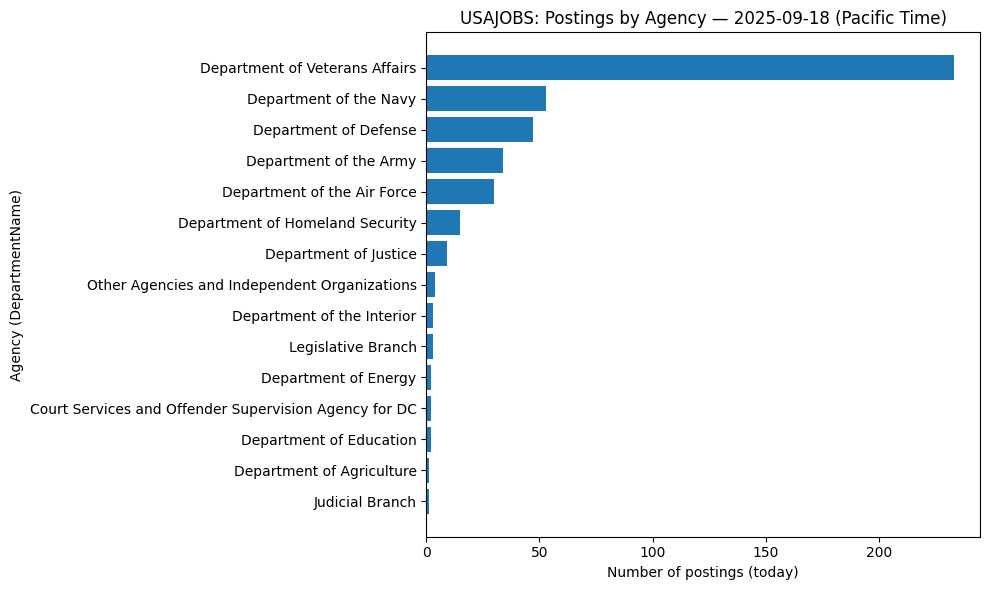

In [8]:
# Colab cell: fetch jobs posted today (Pacific Time) and plot counts by agency
!pip install requests pandas matplotlib --quiet

import time, requests, pandas as pd
from datetime import datetime
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt

USER_EMAIL = "your.email@example.com"
AUTH_KEY = "O1r4r5dR9OuFg8dyHJD8QBpcEVYOrugWVeiBS6AslRY="

class USAJobsClient:
    def __init__(self, user_email, auth_key, base_url="https://data.usajobs.gov/api/search", rate_delay=0.2, timeout=30):
        self.headers = {"Host": "data.usajobs.gov", "User-Agent": user_email, "Authorization-Key": auth_key}
        self.base_url = base_url
        self.rate_delay = rate_delay
        self.timeout = timeout
    def _request(self, params):
        r = requests.get(self.base_url, headers=self.headers, params=params, timeout=self.timeout)
        r.raise_for_status()
        return r.json()
    def search(self, results_per_page=500, max_pages=10, **query):
        page = 1
        results_per_page = max(1, min(int(results_per_page), 500))
        while True:
            payload = {"ResultsPerPage": results_per_page, "Page": page}
            payload.update({k: v for k, v in query.items() if v is not None})
            data = self._request(payload)
            items = data.get("SearchResult", {}).get("SearchResultItems", []) or []
            for item in items:
                d = item.get("MatchedObjectDescriptor", {}) or {}
                yield {
                    "job_id": d.get("PositionID"),
                    "title": d.get("PositionTitle"),
                    "organization": d.get("OrganizationName"),
                    "department": d.get("DepartmentName"),
                    "locations": [loc.get("LocationName") for loc in d.get("PositionLocation", [])] if d.get("PositionLocation") else [],
                    "open_date": d.get("PublicationStartDate"),
                    "close_date": d.get("ApplicationCloseDate"),
                    "apply_uri": (d.get("ApplyURI", []) or [None])[0]
                }
            count_all = data.get("SearchResult", {}).get("SearchResultCountAll", 0)
            number_pages = int(data.get("SearchResult", {}).get("UserArea", {}).get("NumberOfPages", 0))
            page += 1
            if (max_pages and page > max_pages) or page > max(1, number_pages) or (page - 1) * results_per_page >= count_all:
                break
            time.sleep(self.rate_delay)

def parse_dt(s):
    if not s:
        return None
    s = s.replace("Z", "+00:00")
    try:
        dt = datetime.fromisoformat(s)
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=ZoneInfo("UTC"))
        return dt
    except Exception:
        return None

client = USAJobsClient(USER_EMAIL, AUTH_KEY)

rows = list(client.search(
    results_per_page=500,
    max_pages=10,
    DatePosted=1,
    SortField="openingdate",
    SortDirection="desc",
    Fields="Full"
))

df = pd.DataFrame(rows)
if df.empty:
    print("No results found in the last 24 hours.")
else:
    df["open_dt_utc"] = df["open_date"].apply(parse_dt)
    df["open_dt_pacific"] = df["open_dt_utc"].apply(lambda x: x.astimezone(ZoneInfo("America/Los_Angeles")) if x else None)
    df["open_date_pacific"] = df["open_dt_pacific"].apply(lambda x: x.date() if x else None)
    today_pt = datetime.now(ZoneInfo("America/Los_Angeles")).date()
    today_df = df[df["open_date_pacific"] == today_pt].copy()
    print(f"Total last 24h: {len(df)}")
    print(f"Posted today ({today_pt} PT): {len(today_df)}")
    if today_df.empty:
        print("No postings today yet.")
    else:
        agency_counts = (today_df.assign(department=today_df["department"].fillna("Unknown"))
                                   .groupby("department", as_index=False)
                                   .size()
                                   .sort_values("size", ascending=False))
        display_cols = ["job_id","title","department","organization","open_date","apply_uri"]
        display(today_df[display_cols].head(20))
        top = agency_counts.head(20)
        plt.figure(figsize=(10,6))
        plt.barh(top["department"][::-1], top["size"][::-1])
        plt.xlabel("Number of postings (today)")
        plt.ylabel("Agency (DepartmentName)")
        plt.title(f"USAJOBS: Postings by Agency — {today_pt} (Pacific Time)")
        plt.tight_layout()
        plt.show()


In [10]:
# pip install requests pandas
import time, requests, pandas as pd
from datetime import datetime

USER_EMAIL = "your.email@example.com"
AUTH_KEY = "O1r4r5dR9OuFg8dyHJD8QBpcEVYOrugWVeiBS6AslRY="
BASE_URL = "https://data.usajobs.gov/api/search"

class USAJobsClient:
    def __init__(self, user_email=USER_EMAIL, auth_key=AUTH_KEY, base_url=BASE_URL, rate_delay=0.2, timeout=30):
        self.headers = {"Host": "data.usajobs.gov", "User-Agent": user_email, "Authorization-Key": auth_key}
        self.base_url = base_url
        self.rate_delay = rate_delay
        self.timeout = timeout
    def _request(self, params):
        r = requests.get(self.base_url, headers=self.headers, params=params, timeout=self.timeout)
        r.raise_for_status()
        return r.json()
    def search_raw(self, results_per_page=500, max_pages=2, **query):
        page = 1
        results_per_page = max(1, min(int(results_per_page), 500))
        while True:
            payload = {"ResultsPerPage": results_per_page, "Page": page}
            payload.update({k: v for k, v in query.items() if v is not None})
            data = self._request(payload)
            items = data.get("SearchResult", {}).get("SearchResultItems", []) or []
            for item in items:
                yield item.get("MatchedObjectDescriptor", {}) or {}
            count_all = data.get("SearchResult", {}).get("SearchResultCountAll", 0)
            number_pages = int(data.get("SearchResult", {}).get("UserArea", {}).get("NumberOfPages", 0))
            page += 1
            if (max_pages and page > max_pages) or page > max(1, number_pages) or (page - 1) * results_per_page >= count_all:
                break
            time.sleep(self.rate_delay)

def _first(lst, key):
    if isinstance(lst, list) and lst:
        return lst[0].get(key)
    return None

def _join(lst, key=None):
    if not lst: return None
    if key:
        return ", ".join([str(x.get(key)) for x in lst if isinstance(x, dict) and x.get(key) is not None]) or None
    return ", ".join([str(x) for x in lst]) or None

def _locations(locs):
    if not isinstance(locs, list): return None
    return ", ".join([l.get("LocationName") for l in locs if isinstance(l, dict) and l.get("LocationName")]) or None

def flatten_descriptor(d):
    ua = d.get("UserArea", {}) or {}
    details = ua.get("Details", {}) if isinstance(ua, dict) else {}
    return {
        "job_id": d.get("PositionID"),
        "title": d.get("PositionTitle"),
        "position_uri": d.get("PositionURI"),
        "department": d.get("DepartmentName"),
        "organization": d.get("OrganizationName"),
        "series_codes": _join(d.get("JobCategory"), "Code"),
        "series_names": _join(d.get("JobCategory"), "Name"),
        "grades": _join(details.get("JobGrade"), "Code"),
        "service_type": details.get("ServiceType"),
        "who_may_apply": (details.get("WhoMayApply") or {}).get("Name") if isinstance(details.get("WhoMayApply"), dict) else None,
        "position_schedule": _join(d.get("PositionSchedule"), "Name"),
        "offering_type": _join(d.get("PositionOfferingType"), "Name"),
        "security_clearance": _join(d.get("SecurityClearance"), "Name"),
        "drug_test_required": d.get("DrugTestRequiredIndicator"),
        "remote_indicator": d.get("RemoteIndicator"),
        "locations": _locations(d.get("PositionLocation")),
        "min_salary": _first(d.get("PositionRemuneration"), "MinimumRange"),
        "max_salary": _first(d.get("PositionRemuneration"), "MaximumRange"),
        "rate_interval": _first(d.get("PositionRemuneration"), "RateIntervalCode"),
        "publication_start": d.get("PublicationStartDate"),
        "application_close": d.get("ApplicationCloseDate"),
        "position_start": d.get("PositionStartDate"),
        "position_end": d.get("PositionEndDate"),
        "travel_percentage": d.get("TravelPercentage"),
        "apply_uri": (_first([{"Apply": u} for u in (d.get("ApplyURI") or [])], "Apply")),
        "qualification_summary": d.get("QualificationSummary"),
        "position_benefits": d.get("PositionBenefits"),
        "position_incentive": d.get("PositionIncentive"),
    }

def fetch_usajobs_df(keyword=None, location=None, series=None, date_posted=None, results_per_page=500, max_pages=2):
    client = USAJobsClient()
    q = {}
    if keyword: q["Keyword"] = keyword
    if location: q["LocationName"] = location
    if series: q["JobCategoryCode"] = series
    if date_posted is not None: q["DatePosted"] = int(date_posted)  # 0–60 days
    rows = [flatten_descriptor(d) for d in client.search_raw(results_per_page=results_per_page, max_pages=max_pages, **q)]
    return pd.DataFrame(rows)

# Example usage:
df = fetch_usajobs_df(keyword="Data Scientist", location="Washington, DC", date_posted=7, max_pages=3)
df.head()


,job_id,title,position_uri,department,organization,series_codes,series_names,grades,service_type,who_may_apply,...,rate_interval,publication_start,application_close,position_start,position_end,travel_percentage,apply_uri,qualification_summary,position_benefits,position_incentive
0,HRM-DE(DHA)-12798802-MEB,Supervisory Data Scientist,https://www.usajobs.gov:443/job/845792200,Department of Homeland Security,Customs and Border Protection,1560,Data Science Series,None,01,,...,PA,2025-09-15T00:00:00.0000,2025-09-19T23:59:59.9970,2025-09-15T00:00:00.0000,2025-09-19T23:59:59.9970,None,https://www.usajobs.gov:443/job/845792200,Basic Requirement: You must provide supporting...,None,None
1,ST-12800686-25-RMS,MANAGER,https://www.usajobs.gov:443/job/846228800,Department of the Navy,Naval Sea Systems Command,"0801, 0830, 0850, 0855, 1310","General Engineering, Mechanical Engineering, E...",None,01,,...,PA,2025-09-18T00:00:00.0000,2025-09-24T23:59:59.9970,2025-09-18T00:00:00.0000,2025-09-24T23:59:59.9970,None,https://www.usajobs.gov:443/job/846228800,Your resume must demonstrate at least one year...,None,None
2,HRM-SMP-12796410-JPH,Supervisory Computer Scientist,https://www.usajobs.gov:443/job/845775200,Department of Homeland Security,Customs and Border Protection,1550,Computer Science,None,01,,...,PA,2025-09-15T00:00:00.0000,2025-09-19T23:59:59.9970,2025-09-15T00:00:00.0000,2025-09-19T23:59:59.9970,None,https://www.usajobs.gov:443/job/845775200,Basic Requirement: You must provide supporting...,None,None
3,1248056,Research Scientist/Computer Systems Researcher...,https://www.usajobs.gov:443/job/846087500,Department of Defense,National Security Agency/Central Security Service,0132,Intelligence,None,02,,...,PA,2025-09-16T11:29:18.7200,2025-09-21T23:59:59.9970,2025-09-16T11:29:18.7200,2025-09-21T23:59:59.9970,None,https://www.usajobs.gov:443/job/846087500,The qualifications listed are the minimum acce...,None,None
